In [1]:
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np
import matplotlib.pyplot as plt


from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

from scipy.optimize import minimize

from scipy.stats import chi2 as chi2_scipy

This notebook walks through an example analysis of the stacked MOS data in Dessert et al. _Science_ 2020 (https://science.sciencemag.org/content/367/6485/1465).  Note that we only include the MOS data (for now) because it has a simpler instrument response, which makes it easier to put everything in a self-containted Jupyter notebook.  If there is interest, I can also add in the PN data in another notebook.  The complication is that half-way through the energy range the PN data changes bin size, which just brings in an additional complication.  Still, keep in mind here that this is only half of the story: the PN data produces comparable limits as the MOS data (see the paper).

Also, note that these are simply examples of analyses that may be performed using the data products in Dessert et al. _Science_ 2020.  The analyses below are not the analyses that go into our main results in that paper.  In Dessert et al. _Science_ 2020 we use a joint likelihood over all observations instead of stacking the data.  The joint likelihood has a variety of advantages relative to stacking the data, as described in the paper.  Still, comparable sensitivity is achieved by stacking the data, and it is certainly easier to make a self-contained Jupyter notebook wiht the stacked data!

Finally, if you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

Please direct any questions to bsafdi@umich.edu.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties.  We will also give a few examples with data from slightly further away from the Galactic Center.  That is, our fiducial dataset uses data from 4 - 45 degrees from the Galactic Center, but we will also analyze data from 60 - 90 degrees away below.  We also give the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

## Load in the data

In [40]:
## signal region (5 - 45 degrees), these are in cts/s/keV
data = np.load("../data/data_mos_sig_ROI.npy")
data_yerrs = np.load("../data/data_errors_mos_sig_ROI.npy")
D_signal = 5.2e28 #exp. avg. D-factor in signal ROI in keV/cm^2

## Background region (60 - 90 degrees), these are in cts/s/keV
data_bkg = np.load("../data/data_mos_back_ROI.npy")
data_yerrs_bkg = np.load("../data/data_errors_mos_back_ROI.npy")
D_bkg = 1.2e28 #exp. avg. D-factor in bkg ROI in keV/cm^2

Energies = np.load("../data/Energies.npy") #keV

#Exposure times for these datasets
Exp = 23.27726013638801e6 #seconds
Exp_bkg = 67.63917495602036e6 #seconds

Let's plots the data

Text(0,0.5,'signal ROI cts/s/keV')

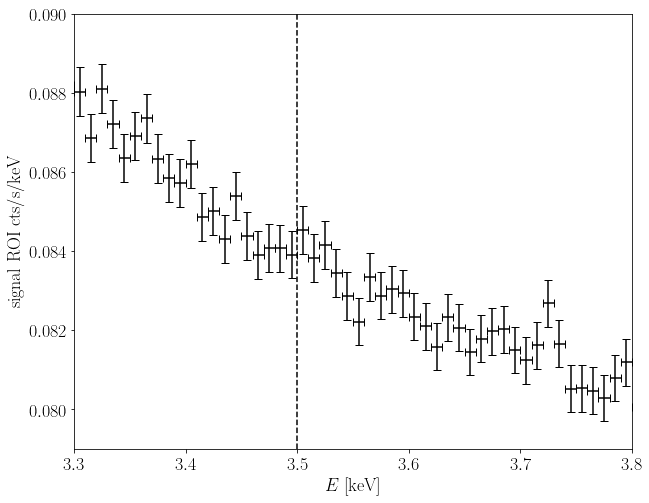

In [41]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)



plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"signal ROI cts/s/keV",fontsize=18)


For one or two examples we will consider subtracting off the data from further away from the GC from the data in our fiducial region.  Note that we refer to the 60 - 90 degree region here as the "background" region.  One reason for doing this is to check if there are instrumental or other backgrounds that are common to the two datasets that for some reason complicate the analysis of the data in the signal ROI alone.  

Below, we show the difference between the two datasets.

Text(0,0.5,'(signal ROI - bkg ROI) cts/s/keV')

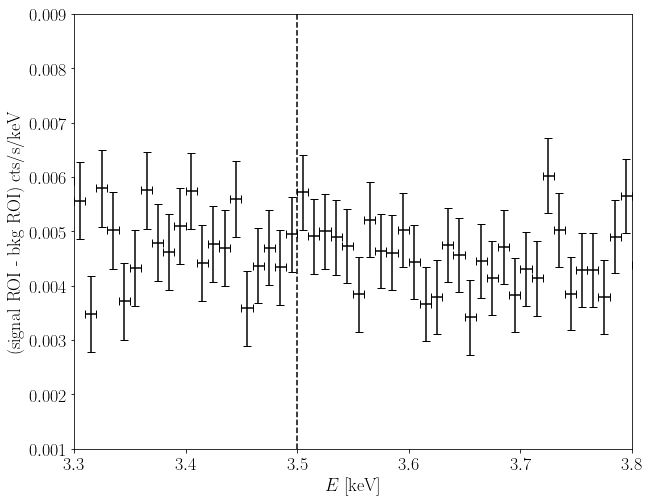

In [42]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)



plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(1e-3,9e-3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"(signal ROI - bkg ROI) cts/s/keV",fontsize=18)


## Load in the Models

Now we are going to load the models.  These models works as follows.  There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_3p5` gives the detectors counts as a function of energy after forward modeling a physical line at 3.5 keV with a flux of 1 cts/cm$^2$/s/sr.

In [68]:
Es_line = np.load("../data/Es_line.npy") #different line energies between 3 and 4 keV
mods = np.load("../data/mods.npy") # All Normed to 1 cts/cm^2/s/sr at the energy in Es_line

# find the best model to describe a 3.5 keV line
arg_3p5 = np.argmin((Es_line-3.5)**2)
mod_3p5 = mods[arg_3p5]
print "The energy of our 3.5 keV line example will be: ", Es_line[arg_3p5]

The energy of our 3.5 keV line example will be:  3.5025041736227047


### An aside: what flux do we need to simply over-produce the observed data?

Suppose that we simply wanted to over-produce the data, without any background modelling assumptions.  This leads to a limit of $\sin^2(2\theta) \lesssim 10^{-10}$-ish, as shown below.

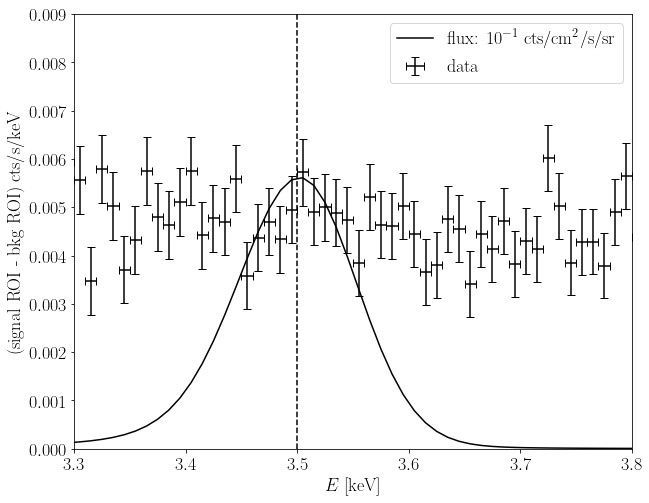

In [69]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)

plt.plot(Energies,1e-1*mod_3p5,'k-',label =r"flux: $10^{-1}$ cts/cm$^2$/s/sr")


plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(0,9e-3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"(signal ROI - bkg ROI) cts/s/keV",fontsize=18)
plt.legend(fontsize=18)


From the plot above it is pretty clear that, regardless of background modeling, a DM signal that produces a flux  $\sim 10^{-1}$ cts/cm$^2$/s/sr more in the signal region versus the background region will overproduce the observed data, regardless of any modeling of astrophysical contributions to the data.  Of course, we will do better than this by modeling the continum emission and also using a statistical analysis, but first let's just a feel for what this flux corresponds to in terms of the limit on $\sin^2(2\theta)$.  

In [70]:
def return_sin_theta_lim(E_line,flux,D_factor):
    '''
    D_factor: keV/cm^2
    flux: cts/cm^2/s/sr
    E_line: keV (not mass is at twice this value)
    returns: limit on sin^2(2\theta)
    '''
    masses = 2*E_line
    res = 1e-10*(4*np.pi*masses/D_factor)/1.38e-32*(1/masses)**5*flux
    return res

In [71]:
print '''The "by eye" limit from the plot above is then sin^2(2 theta) < ''', return_sin_theta_lim(3.5,1e-1,D_signal-D_bkg)



The "by eye" limit from the plot above is then sin^2(2 theta) <  9.48153442584e-11


So, what we have learned is that for $\sin^2(2 \theta) > 10^{-10}$, approximately, we would simply overproduce the observed data, regardless of other sources of flux.  Interestingly, looking at Fig. 1 of Dessert et al. 2020, this is already a relevant constraint.  We will now improve upon this limit by modeling the continuum.

# Statistical analysis

Now, let's do a rigerous statistical analysis, using profile likelihood.

In [72]:
class chi2:
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig
        
        
    
    
def mod_poly(ens,x):
    A, B, C = x
    return A+B*ens + C*ens**2

### Fit within 3.3 to 3.8 keV

First, we will fit the models from 3.3 to 3.8 keV.  At the end, we broaden this range to 3.0 to 4.0 keV.

In [73]:
whs_reduced = np.where((Energies >= 3.3) & (Energies <= 3.8))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_3p5_reduced = mod_3p5[whs_reduced]


In [74]:
chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly,mod_3p5_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3,-0.1,0.01]),method='Nelder-Mead')

mn = minimize(chi2_instance.chi2,np.array([1e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2]]),method='Nelder-Mead')

#mn_null = minimize(chi2_instance.chi2_null,np.array([1e-1,1e-1/3.0,1e-1/3.0**2]),method='Nelder-Mead')

print mn.x
print "The delta \chi^2 between signal and null model is: ", mn_null.fun - mn.fun
print "The \chi^2 / DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-3.)

print "Expected 68\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)
print "Expected 95\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)



[-0.00166926  0.36673112 -0.14536609  0.01845055]
The delta \chi^2 between signal and null model is:  0.10473821693721774
The \chi^2 / DOF of the null-model fit is : 0.6799248225595458
Expected 68\% containment for the \chi^2/DOF:  [0.79617522 1.20353891]
Expected 95\% containment for the \chi^2/DOF:  [0.63736587 1.44299249]


So, in this example the null model is a really good fit! It is actually such a good fit that the $\chi^2 / {\rm DOF}$ is outside of the 68\% expectation, though it is within the 95\% expectation.  Also, note that the $\delta \chi^2$ between the signal and null models, which are nested with the signal model having one additional DOF, is small (~0.1) and that the best-fit signal model parameter is actually slightly negative.

Below, we plot the best-fit null model

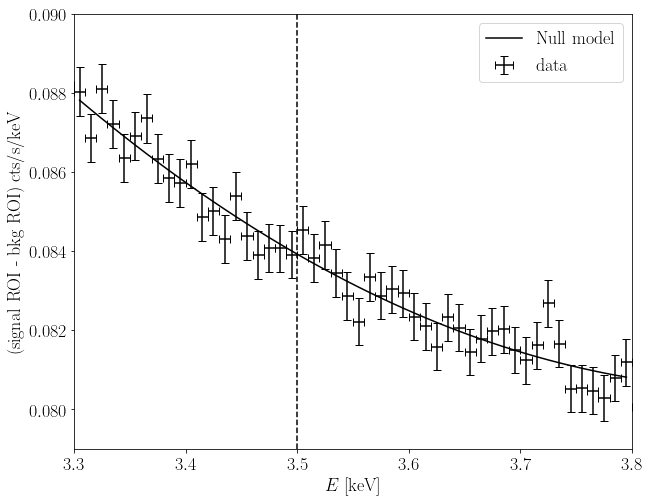

In [75]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)


plt.plot(Energies_reduced,mod_poly(Energies_reduced,mn_null.x),'k-',label =r"Null model")


plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"(signal ROI - bkg ROI) cts/s/keV",fontsize=18)
plt.legend(fontsize=18)


### Profile likelihood

Now, let's construct the profile likelihood to get an approximate 95\% upper limit.  I say approximate because we are going to assume Wilks' theorem and simply look for values of the signal parameter for which the profile likelihood rises above ~2.71 from the minimum.  To be completely rigerous, this step should be constructed from MC simulations.

In [76]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun


In [77]:
amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95\% upper limit on the signal flux is ", limit_signal_strength, " cts/cm^2/s/sr"
print "This corresponds to a limit on \sin^2(2\theta) of ", return_sin_theta_lim(3.5,limit_signal_strength,D_signal)

The 95\% upper limit on the signal flux is  0.00824706404676109  cts/cm^2/s/sr
This corresponds to a limit on \sin^2(2	heta) of  6.014986282422538e-12


So, we see that modeling the background and using a statistical analysis gives us an improved limit relative to simply not overshooting the data (by a factor ~10 - 20).  Below, we plot the profile likelihood  

Text(0,0.5,'$\\delta \\chi^2$')

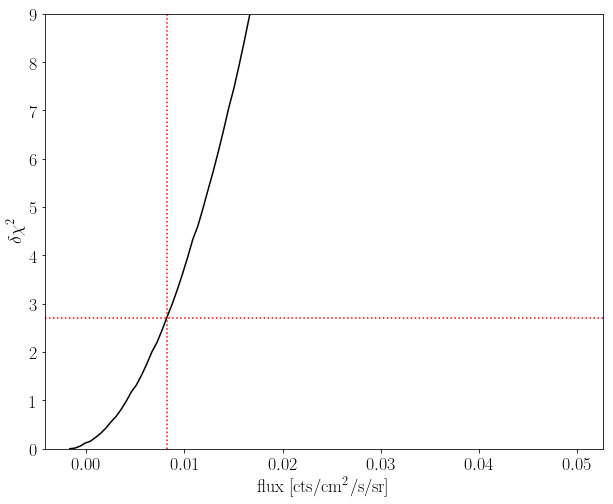

In [78]:
fig = plt.figure(figsize=(10,8))
plt.plot(A_sig_array,chi2_sig_array-chi2_sig_array[0],'k-')
plt.ylim(0,9)
plt.axhline(2.71,color="red",linestyle="dotted")
plt.axvline(limit_signal_strength,color="red",linestyle="dotted")

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"flux [cts/cm$^2$/s/sr]",fontsize=18)
plt.ylabel(r"$\delta \chi^2$",fontsize=18)

#### Fitting to the signal ROI  - background ROI data

While we are at it, let's do a fit to the signal - background data (the data we illustrated by eye earlier).  We don't expect to get a stronger limit, since we are actually only increasing the statistical uncertainties in doing this, but we might reduce systematics associated with e.g. instrumental lines that would be common to both datasets.

In [79]:
chi2_smb_instance = chi2(Energies_reduced,data_reduced-data_bkg_reduced,np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_poly,mod_3p5_reduced)


mn_null = minimize(chi2_smb_instance.chi2_null,np.array([0.005,-0.001,0.001]),method='Nelder-Mead')

mn = minimize(chi2_smb_instance.chi2,np.array([1e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2]]),method='Nelder-Mead')

#mn_null = minimize(chi2_instance.chi2_null,np.array([1e-1,1e-1/3.0,1e-1/3.0**2]),method='Nelder-Mead')

print mn.x
print "The delta \chi^2 between signal and null model is: ", mn_null.fun - mn.fun
print "The \chi^2 / DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-3.)

print "Expected 68\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)
print "Expected 95\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)



[ 3.58562324e-03  6.93589322e-03 -5.28628641e-04 -3.78262942e-05]
The delta \chi^2 between signal and null model is:  0.4317420879473701
The \chi^2 / DOF of the null-model fit is : 0.9183029704107314
Expected 68\% containment for the \chi^2/DOF:  [0.79617522 1.20353891]
Expected 95\% containment for the \chi^2/DOF:  [0.63736587 1.44299249]


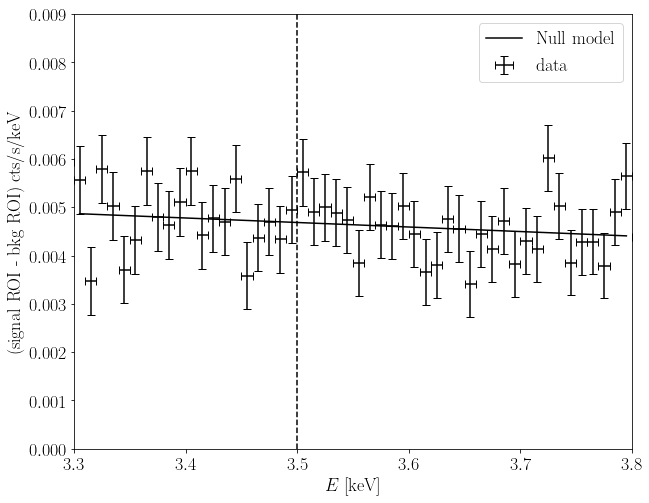

In [80]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2 + data_yerrs_bkg**2),xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)


plt.plot(Energies_reduced,mod_poly(Energies_reduced,mn_null.x),'k-',label =r"Null model")


plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(0,9e-3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"(signal ROI - bkg ROI) cts/s/keV",fontsize=18)
plt.legend(fontsize=18)


In this case we find that the best-fit signal strength is positive (~$3 \times 10^{-3}$ cts/cm$^2$/s), though only at the level $\delta \chi^2 \sim 0.4$, which is negligable significance.  The null model again is a good description of the data, and in particular the $\chi^2 / {\rm DOF}$ is within the 68\% expectation.

In [81]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_smb_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_smb_instance.chi2_fixed_signal,bf,method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95\% upper limit on the signal flux is ", limit_signal_strength, " cts/cm^2/s/sr"
print "This corresponds to a limit on \sin^2(2\theta) of ", return_sin_theta_lim(3.5,limit_signal_strength,D_signal-D_bkg)

The 95\% upper limit on the signal flux is  0.023745403045645493  cts/cm^2/s/sr
This corresponds to a limit on \sin^2(2	heta) of  2.251428564327923e-11


This analysis gives a slightly weaker limit (flux less than $2 \times 10^{-2}$ cts/cm$^2$/s/sr as opposed to $8 \times 10^{-3}$ cts/cm$^2$/s/sr from the fit to the signal only data).  This is likely because (i) it just so happened that the best-fit value was slightly positive in this case, instead of slightly negative, and (ii) we did slightly increase the stat. uncertainties by subtracting the bkg data.  Still, note that this limit also, even though weaker, still strongly constrains the DM interpretation of the 3.5 keV line (see Dessert et al. 2020 Fig. 1).

Also note that the translation from flux limits to limits on $\sin^2(2\theta)$ is affected by the fact that some signal would appear in the bkg region, which is why we subtracted the D-factor from the background region.  This reduces the sensitivity.

#### Extra background line?

Let's now suppose that there are background lines at 3.3 keV and 3.7 keV.  How does this change the limit and do we find evidence for a 3.5 keV line in this case? Note that we expect the limit to be weaker in this case, since there is more degeneracy between the signal and background model.  Let's see how this goes ...


In [82]:
arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p3]

def mod_poly_two_lines(ens,x):
    A, B, C,S1,S2 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

In [83]:
chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_3p5_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3667,-0.1453, 0.01845,1e-3,1e-3]),method='Nelder-Mead')

mn = minimize(chi2_instance.chi2,np.array([1e-3,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})

#mn_null = minimize(chi2_instance.chi2_null,np.array([1e-1,1e-1/3.0,1e-1/3.0**2]),method='Nelder-Mead')

print mn.x
print "The delta \chi^2 between signal and null model is: ", mn_null.fun - mn.fun
print "The \chi^2 / DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-5.)

print "Expected 68\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)



[ 0.0027975   0.26244355 -0.08853585  0.01071035  0.03247648 -0.01450284]
The delta \chi^2 between signal and null model is:  0.9696334207513964
The \chi^2 / DOF of the null-model fit is : 0.7038562959052345
Expected 68\% containment for the \chi^2/DOF:  [0.79175881 1.20794392]
Expected 95\% containment for the \chi^2/DOF:  [0.63035894 1.45355909]


Here we see that including the extra two lines does not make much of a difference.  The null model is still a good fit to the data and the best-fit signal strength is still consistent with zero at 1$\sigma$.  Below we plot the best-fit.  

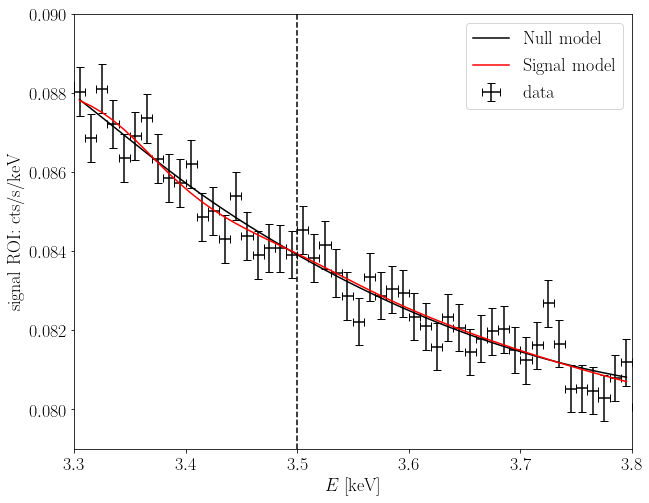

In [84]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)


plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_3p5_reduced,'r-',label =r"Signal model")



plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"signal ROI: cts/s/keV",fontsize=18)
plt.legend(fontsize=18)


In [85]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95\% upper limit on the signal flux is ", limit_signal_strength, " cts/cm^2/s/sr"
print "This corresponds to a limit on \sin^2(2\theta) of ", return_sin_theta_lim(3.5,limit_signal_strength,D_signal)

The 95\% upper limit on the signal flux is  0.0156709064982346  cts/cm^2/s/sr
This corresponds to a limit on \sin^2(2	heta) of  1.1429556880551526e-11


Note that including the background lines made the limit on $\sin^2(2\theta)$ ever so slightly weaker (it went from $6 \times 10^{-12}$ to $1.1 \times 10^{-11}$).  This is because there is now more degeneracy between the signal and backround model, so the effect of a positive signal strenght can be partially removed by the appropriate combination of nuisance parameters.

# Is there something special about 3.3 to 3.8 keV?

No.  We used a narrow energy range to mitigate possible systematic issues due to imperfections in the null model, but this doesn't mean that we find qualitatively different results if we were to use a wider energy range.  Let's explore the energy range from 3.0 to 4.0 keV.

As pointed out in e.g. https://arxiv.org/pdf/1812.10488.pdf, there is a large astrophysical line at ~3.1 keV and also possibly a line at ~3.9 keV.  We will include both of these lines, in addition to the 3.3 and 3.7 keV lines included above.

In [86]:
# First let's redefine the dataset
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_3p5_reduced = mod_3p5[whs_reduced]

In [87]:
arg_3p1 = np.argmin((Es_line-3.12)**2)
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p1]

def mod_poly_four_lines(ens,x):
    A, B, C,S1,S2,S3,S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

In [88]:
chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_3p5_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3667,-0.1453, 0.01845,1e-3,1e-3,1e-2,1e-3]),method='Nelder-Mead')

mn = minimize(chi2_instance.chi2,np.array([1e-3,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})

#mn_null = minimize(chi2_instance.chi2_null,np.array([1e-1,1e-1/3.0,1e-1/3.0**2]),method='Nelder-Mead')

print mn_null.x
print mn.x
print "The delta \chi^2 between signal and null model is: ", mn_null.fun - mn.fun
print "The \chi^2 / DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-5.)

print "Expected 68\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95\% containment for the \chi^2/DOF: ", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)



[ 0.1826114  -0.04374858  0.00443729  0.00832819  0.01207217  0.04884184
  0.02278539]
[ 0.00180894  0.18256964 -0.04380387  0.00445392  0.00803028  0.01322792
  0.04883781  0.02396752]
The delta \chi^2 between signal and null model is:  0.15968049470708934
The \chi^2 / DOF of the null-model fit is : 0.8823439446242881
Expected 68\% containment for the \chi^2/DOF:  [0.85614219 1.14370943]
Expected 95\% containment for the \chi^2/DOF:  [0.73605123 1.30376807]


In [89]:
print "Not that the best-fit signal strength in this case is :", mn.x[0], " cts/cm$^2$/s/sr"

Not that the best-fit signal strength in this case is : 0.0018089362581843122  cts/cm$^2$/s/sr


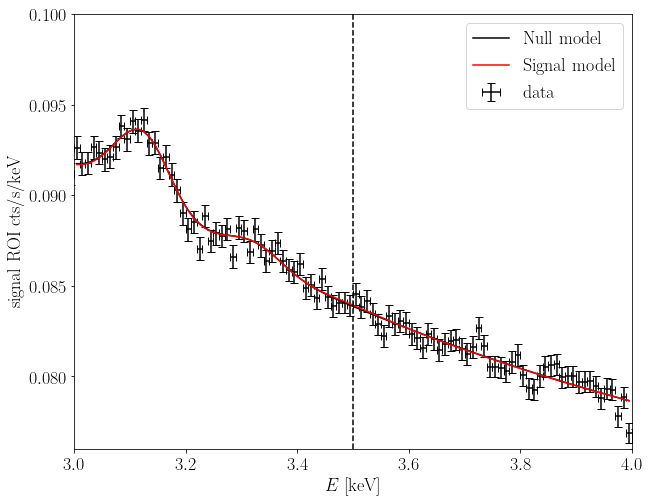

In [90]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)


plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_3p5_reduced,'r-',label =r"Signal model")


plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(7.6e-2,0.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"signal ROI cts/s/keV",fontsize=18)
plt.legend(fontsize=18)


In [91]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95\% upper limit on the signal flux is ", limit_signal_strength, " cts/cm^2/s/sr"
print "This corresponds to a limit on \sin^2(2\theta) of ", return_sin_theta_lim(3.5,limit_signal_strength,D_signal)

The 95\% upper limit on the signal flux is  0.01105772626923985  cts/cm^2/s/sr
This corresponds to a limit on \sin^2(2	heta) of  8.064939407180019e-12


Note that the 95\% upper limit in this case is stronger than it was when using the smaller energy range! That is, the limit went from $\sin^2(2\theta) < 1.1 \times 10^{-11}$ to $\sin^2(2\theta) < 8 \times 10^{-12}$ when increasing the energy range.  This is _precisely_ what you would expect.  Going to a larger energy range better constrains the null model component, which in turn makes the limit and detection capabilities for the signal component stronger.  On the other hand, going to a larger energy range opens one up more to systematic uncetainties, since it is less clear that the null model can describe the data over the full energy range in this case.  This is why we use a narrower energy range and quote the weaker but more conservative limits.

### Mode at fixed signal strength

As a last illustration, let's fix the signal at its 95\% upper limit and see what the model looks like


In [92]:
A_sig = 0.011 #cts/cm^2/s/sr
chi2_instance.fix_signal_strength(A_sig)
mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


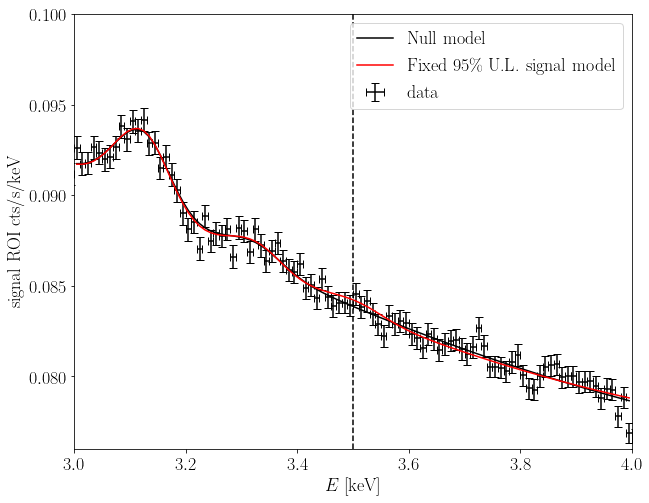

In [93]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)


plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_profile.x)+A_sig*mod_3p5_reduced,'r-',label =r"Fixed 95\% U.L. signal model")


plt.axvline(3.5,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(7.6e-2,0.1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$E$ [keV]",fontsize=18)
plt.ylabel(r"signal ROI cts/s/keV",fontsize=18)
plt.legend(fontsize=18)
